In [1]:
%load_ext autoreload
%autoreload 2
import importlib
import ferbo as fb
importlib.reload(fb)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_vs_parameters
from theory import bloch_andreev_hamiltonian, andreev_bloch_waves

In [5]:
Ej = 2
r = 0.3
Ec = 1
k = 0
N = 6
phi = 0.1
eigvecs = andreev_bloch_waves(phi, Ej, r, Ec, k, N)
eigvecs.shape

(14, 14)

Transmon

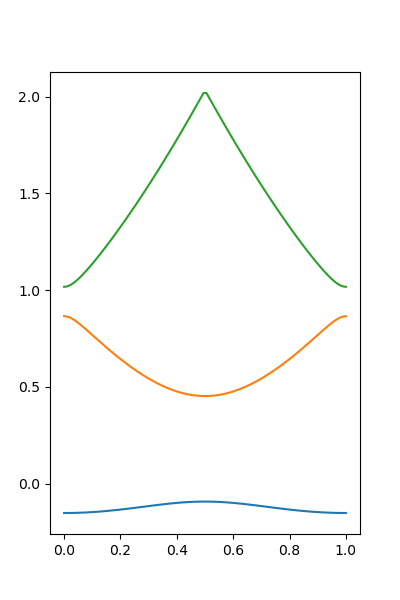

In [25]:
from qutip import charge, tunneling
import matplotlib.pyplot as plt
Nmax = 10
dimension = 2*Nmax + 1
eigvals = 3
Ec, Ej = 1, 2.5
ng_array = np.linspace(0,1, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    transmon = 4*Ec*(charge(Nmax,-Nmax)-ng)**2 - 0.5*Ej*tunneling(dimension)
    eigvals_array[i], eigvecs = transmon.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (4,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
plt.show()

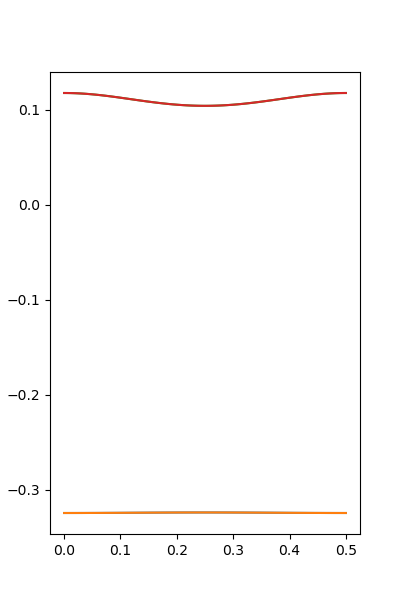

In [5]:
from qutip import charge, tunneling, tensor, sigmaz, qeye
import matplotlib.pyplot as plt
Nmax = 10
dimension = 2*Nmax + 1
eigvals = 4
Ec, Ej = 1, 2.5
ng_array = np.linspace(0,1/2, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) - 0.5*Ej*tensor(tunneling(dimension), sigmaz()) 
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (4,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
plt.show()

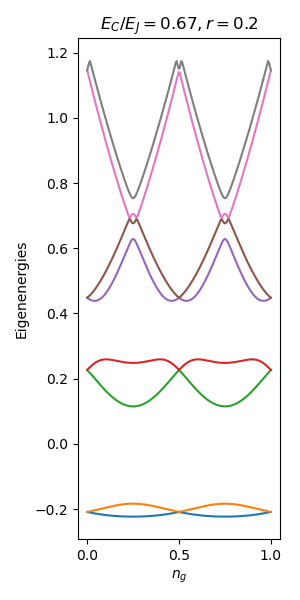

In [30]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
import matplotlib.pyplot as plt
Nmax = 20
r = 0.2
phi_ext = 0
dimension = 2*Nmax + 1
eigvals = 8
Ec, Ej = 1,1.5
ng_array = np.linspace(0,1, 200)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (3,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
ax.set_title(rf'$E_C/E_J = {round(Ec/Ej, 2)}, r = {r}$')
ax.set_xlabel(rf'$n_g$')
ax.set_ylabel(rf'Eigenenergies')
fig.tight_layout()
plt.show()

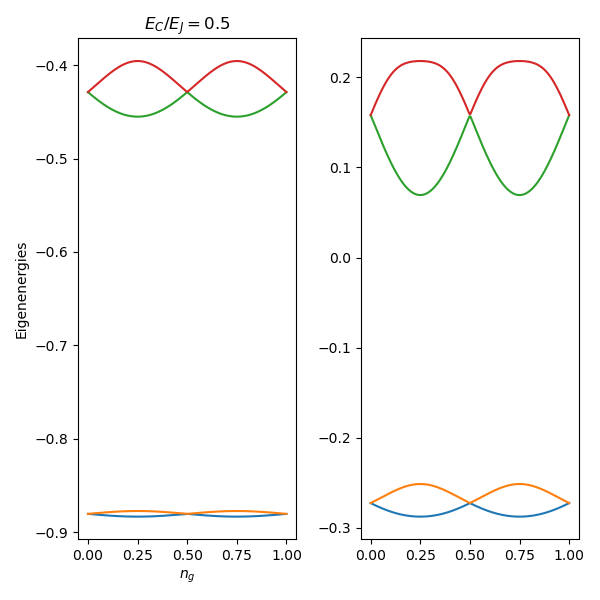

In [41]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
import matplotlib.pyplot as plt
Nmax = 20
r = 0.2
phi_ext = 0
dimension = 2*Nmax + 1
eigvals = 4
ng_array = np.linspace(0,1, 200)
eigvals_array1 = np.zeros((len(ng_array),eigvals))
eigvals_array2 = np.zeros((len(ng_array),eigvals))

Ec1,Ej = 0.1,1
for i, ng in enumerate(ng_array):
    andreev = 4*Ec1*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array1[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

Ec2,Ej = 0.5,1
for i, ng in enumerate(ng_array):
    andreev = 4*Ec2*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array2[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(1,2,figsize = (6,6))
ax[0].plot(ng_array,eigvals_array1/np.sqrt(8*Ej*Ec1))
ax[1].plot(ng_array,eigvals_array2/np.sqrt(8*Ej*Ec2))
ax[0].set_title(rf'$E_C/E_J = {round(Ec1/Ej, 2)}$')
ax[1].set_title(rf'$E_C/E_J = {round(Ec2/Ej, 2)}$')
ax[0].set_xlabel(rf'$n_g$')
ax[0].set_ylabel(rf'Eigenenergies')
fig.tight_layout()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

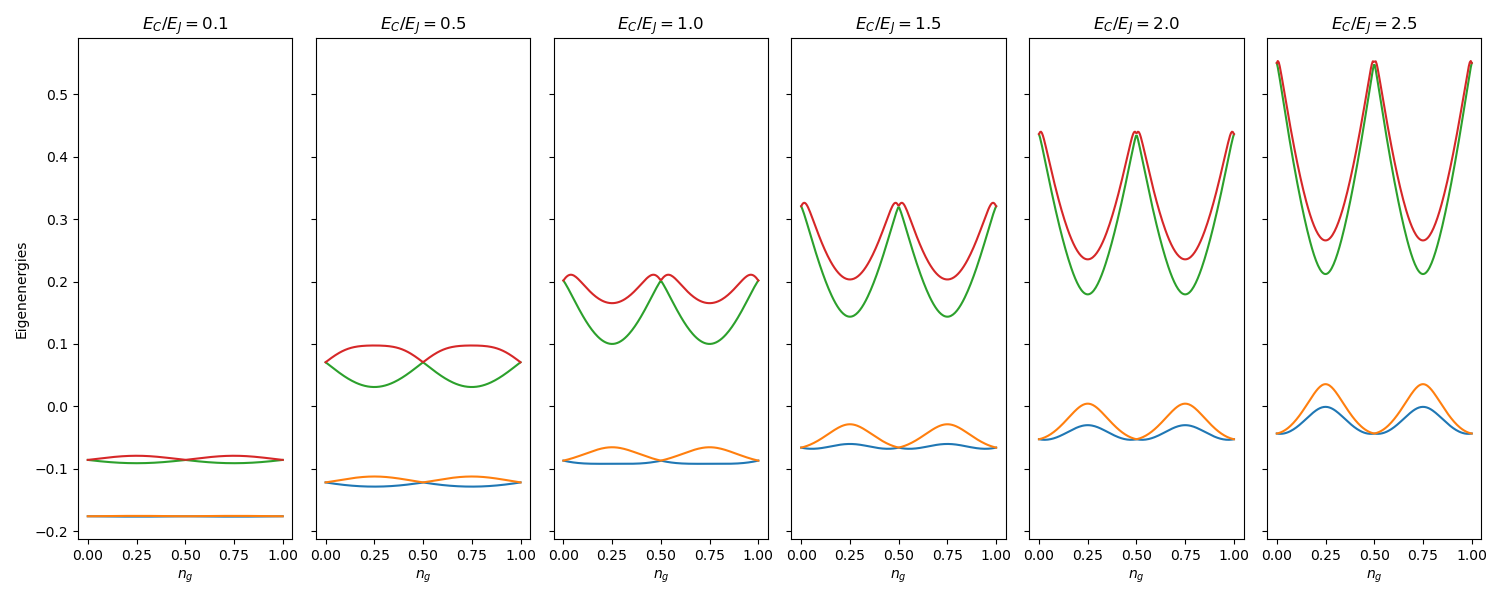

In [8]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
from operators import cos_phi, sin_phi
from utils import plot_vs_parameters
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definir los valores de Ec que deseas considerar
Ec_values = [0.1, 0.5, 1, 1.5, 2, 2.5]

Nmax = 20
r = 0.2
phi_ext = 0
dimension = 2 * Nmax + 1
eigvals = 4
ng_array = np.linspace(0, 1, 200)

# Crear una lista para almacenar los arrays de eigvals correspondientes a cada valor de Ec
eigvals_arrays = []

Ej = 1

# Iterar a través de los valores de Ec
for Ec in tqdm(Ec_values):
    eigvals_array = np.zeros((len(ng_array), eigvals))
    
    for i, ng in enumerate(ng_array):
        andreev = 4 * Ec * tensor((charge(Nmax, -Nmax, frac=1/2) - ng)**2, qeye(2)) + Ej * (tensor(cos_phi(dimension, phi_ext, m=1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m=1), sigmay()))
        eigvals_array[i], eigvecs = andreev.eigenstates(eigvals=eigvals)
    
    # Agregar el array de eigvals a la lista
    eigvals_arrays.append(eigvals_array)

# Crear subplots para cada valor de Ec
x_values_list = [ng_array] * len(Ec_values)
y_values_list = [eigvals_array / np.sqrt(8 * Ej * Ec) for eigvals_array in eigvals_arrays]
parameter_names = [rf'$n_g$'] * len(Ec_values)
ylabels = [rf'Eigenenergies'] * len(Ec_values)
titles = [rf'$E_C/E_J = {round(Ec/Ej, 2)}$' for Ec in Ec_values]

plot_vs_parameters(x_values_list, y_values_list, parameter_names, ylabels, titles, sharey = True)


  0%|          | 0/6 [00:00<?, ?it/s]

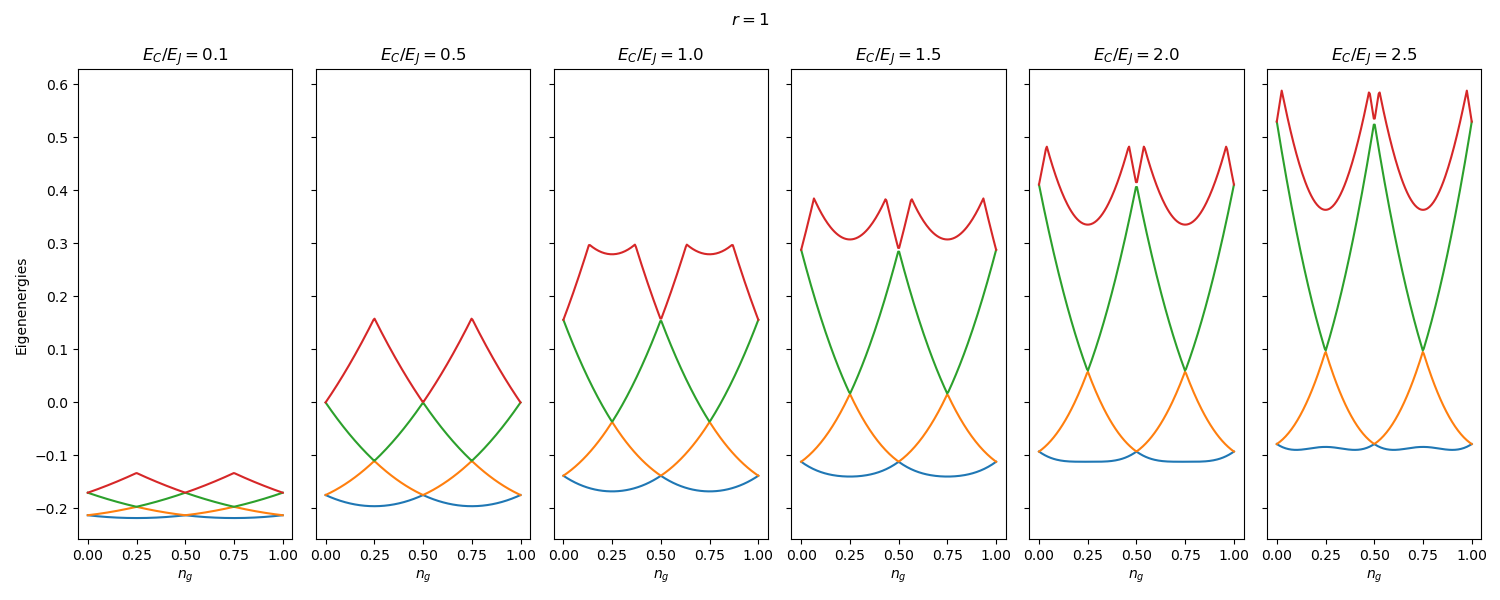

In [19]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
from operators import cos_phi, sin_phi
from utils import plot_vs_parameters
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definir los valores de Ec que deseas considerar
Ec_values = [0.1, 0.5, 1, 1.5, 2, 2.5]

Nmax = 20
r = 1
phi_ext = 0
dimension = 2 * Nmax + 1
eigvals = 4
ng_array = np.linspace(0, 1, 200)

# Crear una lista para almacenar los arrays de eigvals correspondientes a cada valor de Ec
eigvals_arrays = []

Ej = 1

# Iterar a través de los valores de Ec
for Ec in tqdm(Ec_values):
    eigvals_array = np.zeros((len(ng_array), eigvals))
    
    for i, ng in enumerate(ng_array):
        andreev = 4 * Ec * tensor((charge(Nmax, -Nmax, frac=1/2) - ng)**2, qeye(2)) + Ej * (tensor(cos_phi(dimension, phi_ext, m=1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m=1), sigmay()))
        eigvals_array[i], eigvecs = andreev.eigenstates(eigvals=eigvals)
    
    # Agregar el array de eigvals a la lista
    eigvals_arrays.append(eigvals_array)

# Crear subplots para cada valor de Ec
x_values_list = [ng_array] * len(Ec_values)
y_values_list = [eigvals_array / np.sqrt(8 * Ej * Ec) for eigvals_array in eigvals_arrays]
parameter_names = [rf'$n_g$'] * len(Ec_values)
ylabels = [rf'Eigenenergies'] * len(Ec_values)
titles = [rf'$E_C/E_J = {round(Ec/Ej, 2)}$' for Ec in Ec_values]

plot_vs_parameters(x_values_list, y_values_list, parameter_names, ylabels, titles, common_title=rf'$r = {r}$',sharey = True)


  0%|          | 0/8 [00:00<?, ?it/s]

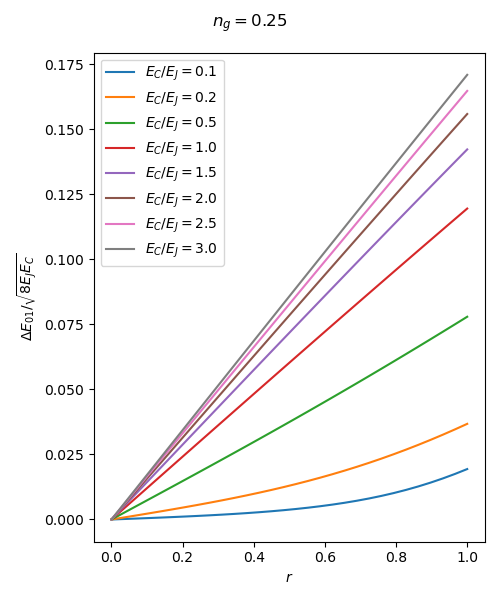

In [30]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
from operators import cos_phi, sin_phi
from utils import plot_vs_parameters
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definir los valores de Ec que deseas considerar
Ec_values = [0.1,0.2, 0.5, 1, 1.5, 2, 2.5, 3]

Nmax = 20
phi_ext = 0
dimension = 2 * Nmax + 1
eigvals = 2
ng = 0.25
r_array = np.linspace(0, 1, 30)
# Crear una lista para almacenar los arrays de eigvals correspondientes a cada valor de Ec
dif_arrays = []

Ej = 1

# Iterar a través de los valores de Ec
for Ec in tqdm(Ec_values):
    dif_array = np.zeros(len(r_array))
    
    for i, r in enumerate(r_array):
        andreev = 4 * Ec * tensor((charge(Nmax, -Nmax, frac=1/2) - ng)**2, qeye(2)) + Ej * (tensor(cos_phi(dimension, phi_ext, m=1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m=1), sigmay()))
        eigvals, eigvecs = andreev.eigenstates(eigvals=4)
        dif = eigvals[1] - eigvals[0]
        dif_array[i] = dif
    
    # Agregar el array de eigvals a la lista
    dif_arrays.append(dif_array)

# Crear subplots para cada valor de Ec
x_values_list = [r_array] * len(Ec_values)
y_values_list = [dif_array/ np.sqrt(8 * Ej * Ec) for dif_array in dif_arrays]
parameter_names = [rf'$r$'] * len(Ec_values)
ylabels = [rf'$\Delta E_{{01}} / \sqrt{{8 E_J E_C}}$'] * len(Ec_values)
titles = [rf'$E_C/E_J = {round(Ec/Ej, 2)}$' for Ec in Ec_values]

plot_vs_parameters(x_values_list, y_values_list, parameter_names, ylabels, titles, common_title=rf'$n_g = {ng}$',sharey = True, single_plot=True, figsize=(5,6))


# Quasimomentum

## Transmon

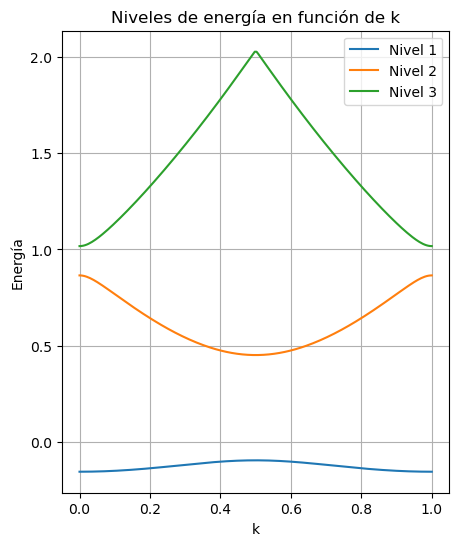

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 1  # Puedes reemplazar esto con el valor que desees
Ej_value = 2.5  # Puedes reemplazar esto con el valor que desees

k_values = np.linspace(0, 1, 200)  # Rango de valores para k
eigenvalues_list = []

def create_matrix(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i)**2
        matrix[i, i-1] = Ej_value / 2
        matrix[i-1, i] = Ej_value / 2
    return matrix

for k in k_values:
    matrix_k = create_matrix(k)
    eigenvalues_k = np.linalg.eigvalsh(matrix_k)
    eigenvalues_list.append(eigenvalues_k)

eigenvalues_array = np.array(eigenvalues_list)

# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(3):
    plt.plot(k_values, eigenvalues_array[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
plt.legend()
plt.grid(True)
plt.show()

## Andreev spin qubit

In [38]:
# Parámetros
Ej = 2
r = 0.3
Ec = 1
k = 0
N = 4
phi = 0.1
# matrix_k = bloch_andreev_hamiltonian(Ej, r, Ec, k, N)
eigvecs, real = andreev_bloch_waves(phi, Ej, r, Ec, k, N)
eigvecs[0]

array([[ 3.62793599e-17, -7.47915961e-02],
       [-2.33989897e-01,  1.26971710e-02],
       [ 8.65691959e-02, -1.76726027e-01],
       [-1.76041032e-01,  6.60799278e-01],
       [ 6.54605517e-01, -6.79183275e-02]])

In [39]:
real[0]

array([ 3.62793599e-17, -7.47915961e-02, -2.33989897e-01,  1.26971710e-02,
        8.65691959e-02, -1.76726027e-01, -1.76041032e-01,  6.60799278e-01,
        6.54605517e-01, -6.79183275e-02])

In [18]:
p = np.array([1,2,3,4,5])

array([ 2,  4,  6,  8, 10])

In [41]:
N = 6
for i, idx in enumerate(range(-N, N + 2)):

    q_val = - (idx // 2) / 2
    print(q_val, idx)

1.5 -6
1.5 -5
1.0 -4
1.0 -3
0.5 -2
0.5 -1
0.0 0
0.0 1
-0.5 2
-0.5 3
-1.0 4
-1.0 5
-1.5 6
-1.5 7


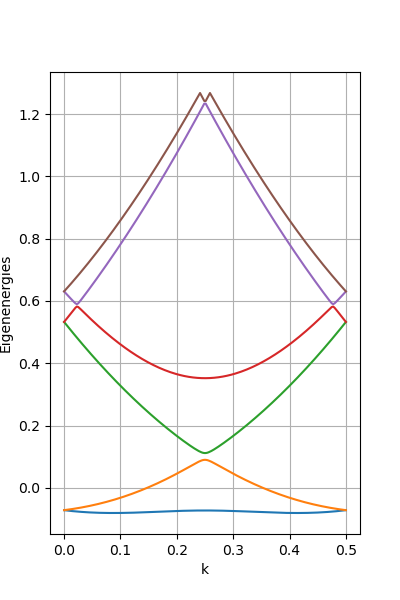

In [10]:
# Parámetros
Ej = 1
r = 0.9
Ec = 2.5
k_values = np.linspace(0,1/2,200)
N = 10  # Tamaño de la matriz, debe ser múltiplo de 4 para este ejemplo
eigenvalues_list = []
for k in k_values:
    matrix_k = bloch_andreev_hamiltonian(Ej, r, Ec, k, N)
    eigenvalues_k = np.linalg.eigvalsh(matrix_k)
    eigenvalues_list.append(eigenvalues_k)

eigenvalues_array = np.array(eigenvalues_list)

plt.figure(figsize=(4, 6))
for i in range(6):
    plt.plot(k_values, eigenvalues_array[:, i]/np.sqrt(8*Ec*Ej))

plt.xlabel("k")
plt.ylabel("Eigenenergies")
plt.grid(True)
plt.show()

In [67]:
np.arange(-3//2,3//2+1)

array([-2, -1,  0,  1])

In [110]:
from sympy import Matrix, symbols

Ej, r, Ec, k = symbols('Ej r Ec k')

def generate_sympy_matrix(Ej, r, Ec, k, N):
    # Inicializar matriz de ceros
    matrix = Matrix.zeros(2*(N+1))
    
    # Llenar la diagonal principal y las sub-diagonales
    for i,idx in enumerate(np.arange(-N,N+2)):

        k_val = k - (idx // 2) / 2
        if matrix[i, i] == 0:
            matrix[i, i] = 4 * Ec * k_val ** 2

        # Llenar las sub-diagonales y super-diagonales
        if i + 1 < 2*(N+1):
            matrix[i, i + 1] = 0 if i % 2 == 0 else -r * Ej / 2
            matrix[i + 1, i] = 0 if i % 2 == 0 else -r * Ej / 2
            
        if i + 2 < 2*(N+1):
            matrix[i, i + 2] = Ej / 2 if i % 2 == 0 else -Ej / 2
            matrix[i + 2, i] = Ej / 2 if i % 2 == 0 else -Ej / 2

        if i + 3 < 2*(N+1):
            matrix[i, i + 3] = -r * Ej / 2 if i % 2 == 0 else 0
            matrix[i + 3, i] = r * Ej / 2 if i % 2 == 0 else 0
    return matrix

N = 6  # Tamaño de la matriz, debe ser múltiplo de 4

# Generar la matriz simbólica
matrix_sympy = generate_sympy_matrix(Ej, r, Ec, k, N)

# Mostrar la matriz
print("Matriz simbólica generada:")
print(matrix_sympy)


Matriz simbólica generada:
Matrix([[9.0*Ec*(0.666666666666667*k + 1)**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 9.0*Ec*(0.666666666666667*k + 1)**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [Ej/2, -Ej*r/2, 4*Ec*(k + 1.0)**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0, 0, 0, 0, 0], [Ej*r/2, -Ej/2, 0, 4*Ec*(k + 1.0)**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, Ej/2, -Ej*r/2, 4*Ec*(k + 0.5)**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0, 0, 0], [0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*(k + 0.5)**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, Ej/2, -Ej*r/2, 4*Ec*k**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0], [0, 0, 0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*k**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, Ej/2, -Ej*r/2, 4*Ec*(k - 0.5)**2, 0, Ej/2, -Ej*r/2, 0, 0], [0, 0, 0, 0, 0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*(k - 0.5)**2, -Ej*r/2, -Ej/2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, Ej/2, -Ej*r/2, 4*Ec*(k - 1.0)**2, 0, Ej/2, -Ej*r/2], [0, 0, 0, 0, 0, 0, 0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*(k - 1.0)**2, -Ej*r/2, -Ej/2], [0, 0, 0, 0, 0, 0, 0,

In [111]:
from sympy import pprint
pprint(matrix_sympy, use_unicode=True)

⎡                                2                                           E
⎢9.0⋅Ec⋅(0.666666666666667⋅k + 1)                   0                        ─
⎢                                                                            2
⎢                                                                             
⎢                                                                   2      -Ej
⎢                0                  9.0⋅Ec⋅(0.666666666666667⋅k + 1)       ───
⎢                                                                            2
⎢                                                                             
⎢               Ej                               -Ej⋅r                        
⎢               ──                               ──────                4⋅Ec⋅(k
⎢               2                                  2                          
⎢                                                                             
⎢              Ej⋅r                               -E

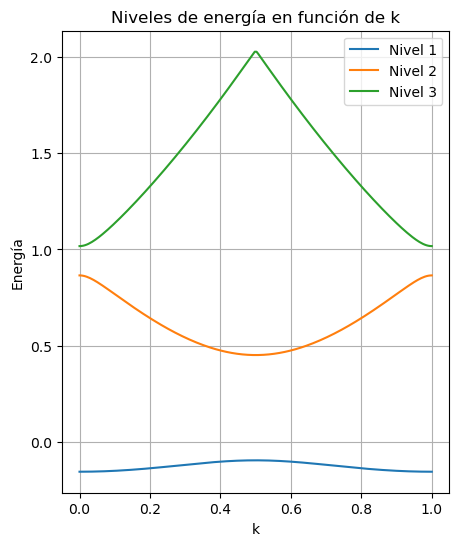

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 1  # Puedes reemplazar esto con el valor que desees
Ej_value = 2.5  # Puedes reemplazar esto con el valor que desees

k_values = np.linspace(0, 1, 200)  # Rango de valores para k
eigenvalues_list = []

def create_matrix_andreev(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = Ej_value / 2
        matrix[i-1, i] = Ej_value / 2
    return matrix

for k in k_values:
    matrix_k = create_matrix_andreev(k)
    eigenvalues_k = np.linalg.eigvalsh(matrix_k)
    eigenvalues_list.append(eigenvalues_k)

eigenvalues_array = np.array(eigenvalues_list)

# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(3):
    plt.plot(k_values, eigenvalues_array[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
plt.legend()
plt.grid(True)
plt.show()

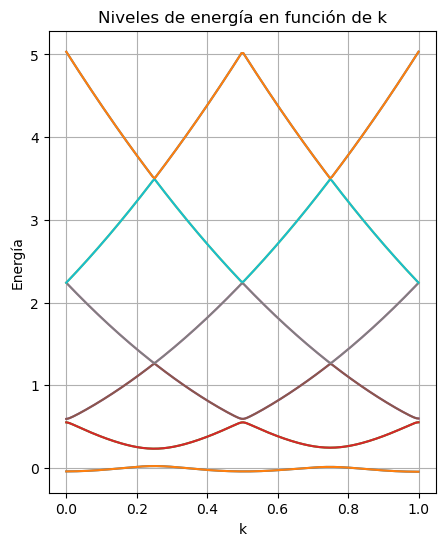

In [20]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 2.5  # Puedes reemplazar esto con el valor que desees
Ej_value = 1  # Puedes reemplazar esto con el valor que desees
r = 0.05

k_values = np.linspace(0, 1, 200)  # Rango de valores para k
eigenvalues_list_up = []
eigenvalues_list_down = []

def create_matrix_up(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = (1+r)* Ej_value / 2
        matrix[i-1, i] = (1-r)* Ej_value / 2
    return matrix

def create_matrix_down(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = -(1+r)* Ej_value / 2
        matrix[i-1, i] = -(1-r)* Ej_value / 2
    return matrix

for k in k_values:
    matrix_k_up = create_matrix_up(k)
    eigenvalues_k_up = np.linalg.eigvalsh(matrix_k_up)
    eigenvalues_list_up.append(eigenvalues_k_up)

eigenvalues_array_up = np.array(eigenvalues_list_up)

for k in k_values:
    matrix_k_down = create_matrix_down(k)
    eigenvalues_k_down = np.linalg.eigvalsh(matrix_k_down)
    eigenvalues_list_down.append(eigenvalues_k_down)

eigenvalues_array_down = np.array(eigenvalues_list_down)
# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(6):
    plt.plot(k_values, eigenvalues_array_up[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")
    plt.plot(k_values, eigenvalues_array_down[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
# plt.legend()
plt.grid(True)
plt.show()

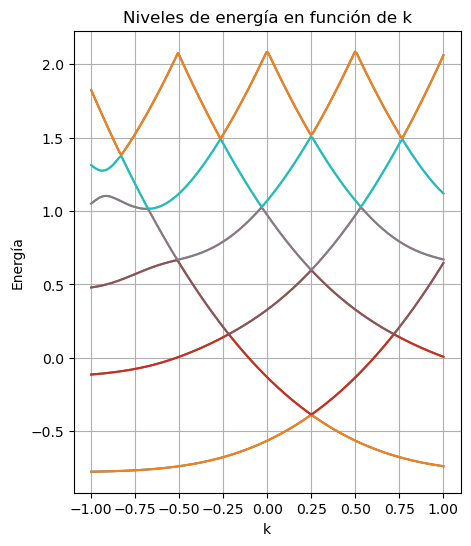

In [23]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 1  # Puedes reemplazar esto con el valor que desees
Ej_value = 2.5  # Puedes reemplazar esto con el valor que desees
r = 0.2

k_values = np.linspace(-1, 1, 200)  # Rango de valores para k
eigenvalues_list = []

def create_matrix_andreev(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i+1] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = (1+r)* Ej_value / 2
        matrix[i-1, i] = (1-r)* Ej_value / 2
    return matrix

def create_matrix_down(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = -(1+r)* Ej_value / 2
        matrix[i-1, i] = -(1-r)* Ej_value / 2
    return matrix

for k in k_values:
    matrix_k_up = create_matrix_up(k)
    eigenvalues_k_up = np.linalg.eigvalsh(matrix_k_up)
    eigenvalues_list_up.append(eigenvalues_k_up)

eigenvalues_array_up = np.array(eigenvalues_list_up)

for k in k_values:
    matrix_k_down = create_matrix_down(k)
    eigenvalues_k_down = np.linalg.eigvalsh(matrix_k_down)
    eigenvalues_list_down.append(eigenvalues_k_down)

eigenvalues_array_down = np.array(eigenvalues_list_down)
# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(6):
    plt.plot(k_values, eigenvalues_array_up[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")
    plt.plot(k_values, eigenvalues_array_down[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
# plt.legend()
plt.grid(True)
plt.show()

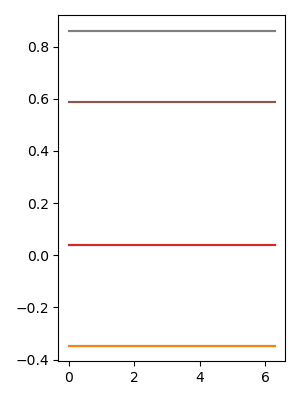

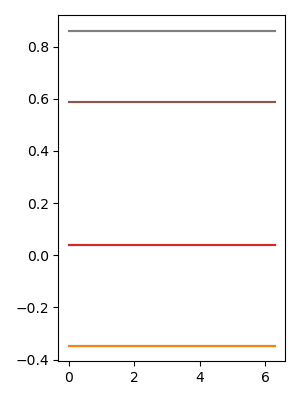

In [9]:
from qutip import charge, tensor, sigmaz, sigmay, qeye, sigmax
import matplotlib.pyplot as plt
Nmax = 10
r = 0.8
ng = 0
dimension = 2*Nmax + 1
eigvals = 8
Ec, Ej = 1,2
phi_array = np.linspace(0,2*np.pi, 100)
eigvals_array = np.zeros((len(phi_array),eigvals))
for i, phi_ext in enumerate(phi_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (3,4))
ax.plot(phi_array,eigvals_array/np.sqrt(8*Ej*Ec))
fig.tight_layout()
plt.show()

Tests

  0%|          | 0/100 [00:00<?, ?it/s]

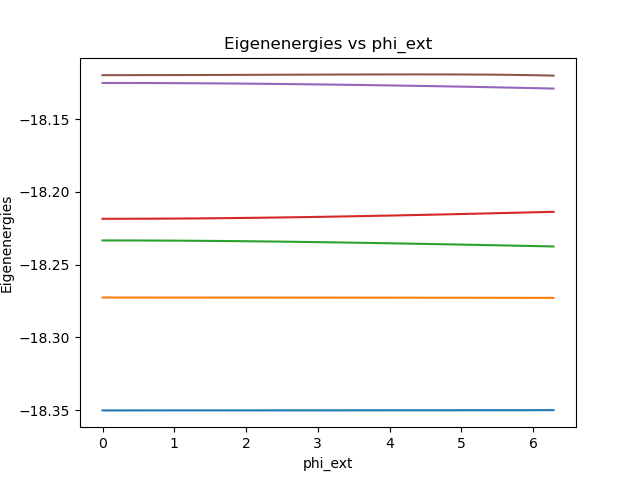

  0%|          | 0/100 [00:00<?, ?it/s]

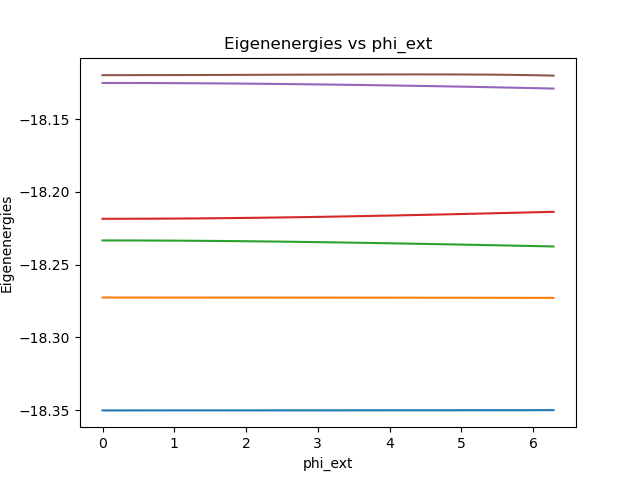

In [10]:
fixed_params = {
    'Ec': 40,
    'El': 0.00001,
    'Delta': 20,
    'r': 0.5,
    'dimension': 100
}

phi_ext_array = np.linspace(0, 2*np.pi, 100)

eigenenergies = fb.eigenenergies_vs_parameter('phi_ext', phi_ext_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

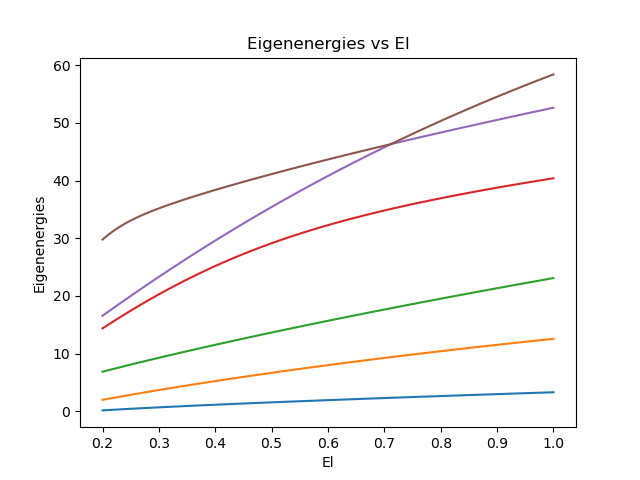

  0%|          | 0/100 [00:00<?, ?it/s]

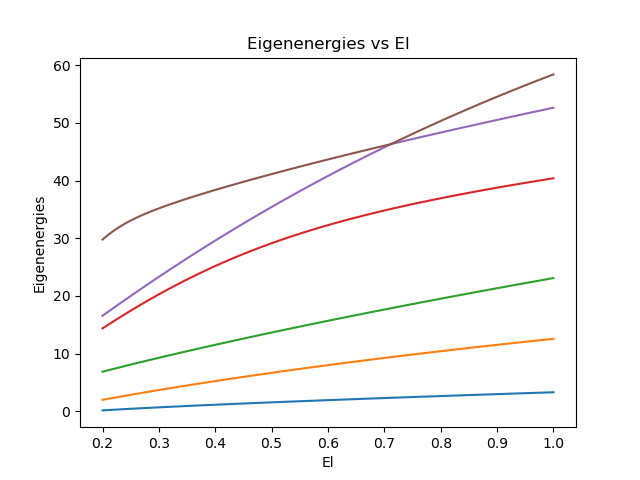

In [11]:
fixed_params = {
    'Ec': 60,
    'Delta': 20,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

El_array = np.linspace(0.2, 1, 100)

eigenenergies = fb.eigenenergies_vs_parameter('El', El_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

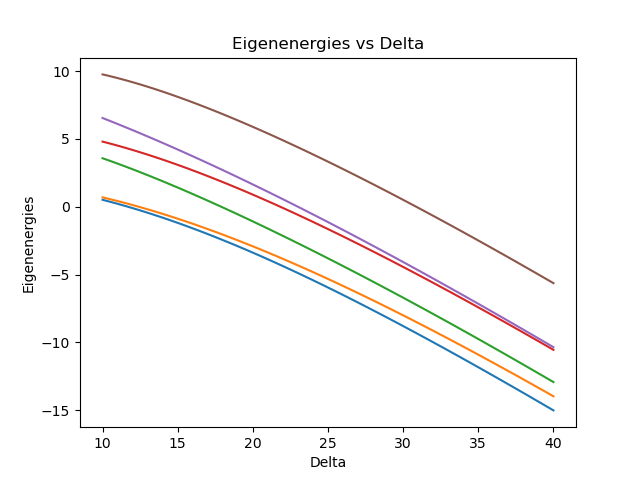

  0%|          | 0/100 [00:00<?, ?it/s]

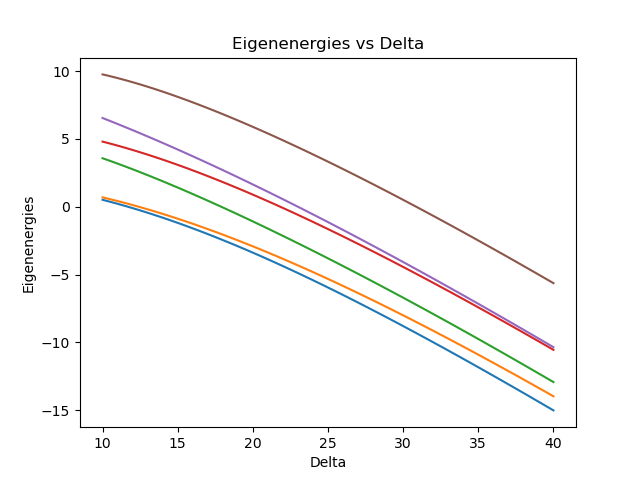

In [12]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

Delta_array = np.linspace(10, 40, 100)

eigenenergies = fb.eigenenergies_vs_parameter('Delta', Delta_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

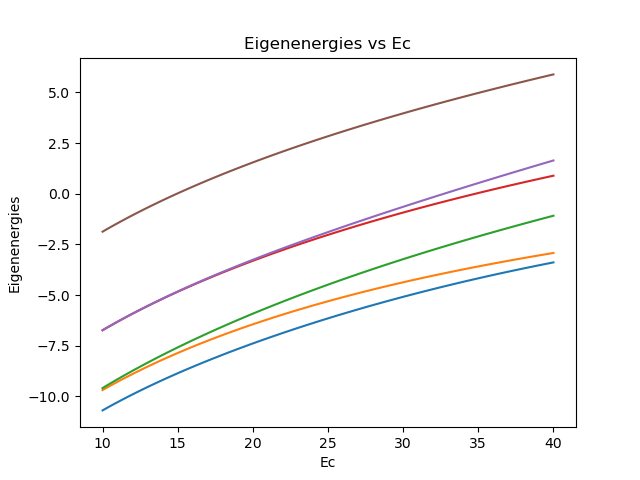

In [13]:
fixed_params = {
    'El': 0.05,
    'Delta' : 20,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

Ec_array = np.linspace(10, 40, 100)

eigenenergies = fb.eigenenergies_vs_parameter('Ec', Ec_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

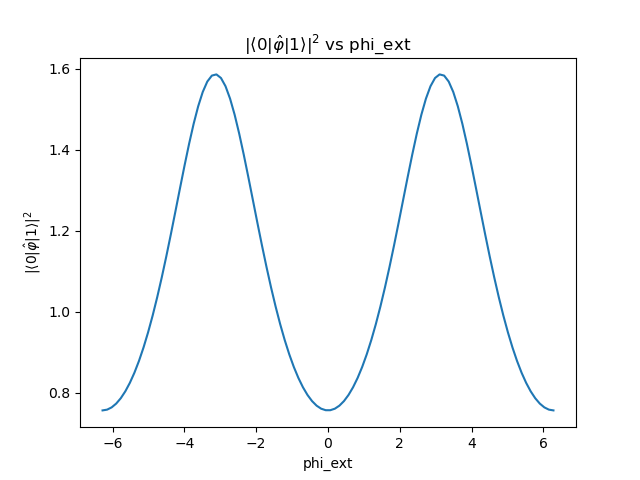

In [14]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

In [15]:
fixed_params = {
    'Ec': 50,
    'Delta': 20,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.linspace(0.01, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/100 [00:00<?, ?it/s]

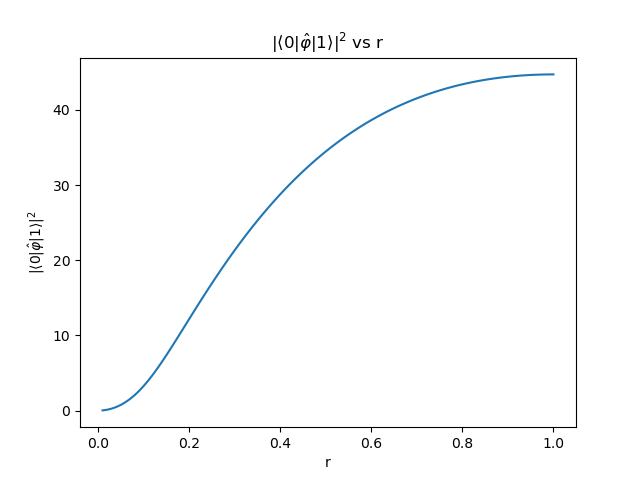

  0%|          | 0/100 [00:00<?, ?it/s]

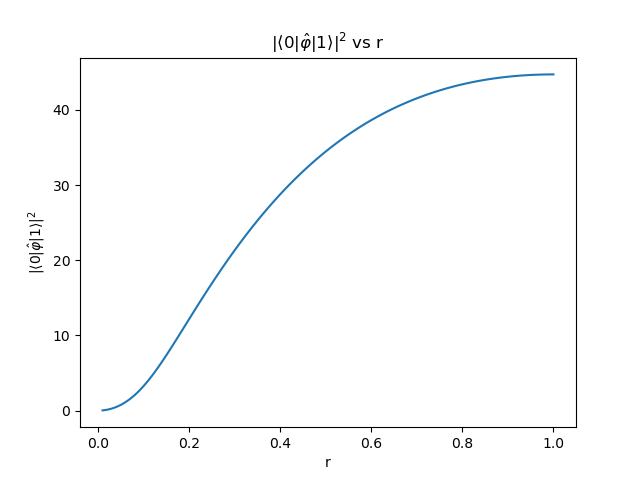

In [ ]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'phi_ext': 0,
    'dimension': 100
}

r_array = np.linspace(0, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='r', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)